Begun 2/7/25

Analyzing results of run using w2 for spectra and w2w4 for mode correction with ell 1000-3000 and bin widths of 400 

Results in angle_calc_1738881756

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1738881756/angle_calc_1738881756_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'fsky', 'w2w4_depth1', 'w2w4_cross', 'w2w4_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
ivar_sums = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
for i in range(n_maps):
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = np.abs(spectra_dict[maps[i]]['residual_sum'])
    all_errbars[i] = np.abs(spectra_dict[maps[i]]['meas_errbar'])
    
print(np.where(residual_sums==9999)[0])   # Maps cut by galaxy mask
print(np.where(all_errbars<0.5)[0])       # Maps where curve_fit failed

[ 43  44  45 109 124 125 126 139 168 229 230 240 241 242 248]
[ 32  40  86 137 188 216 237 258]


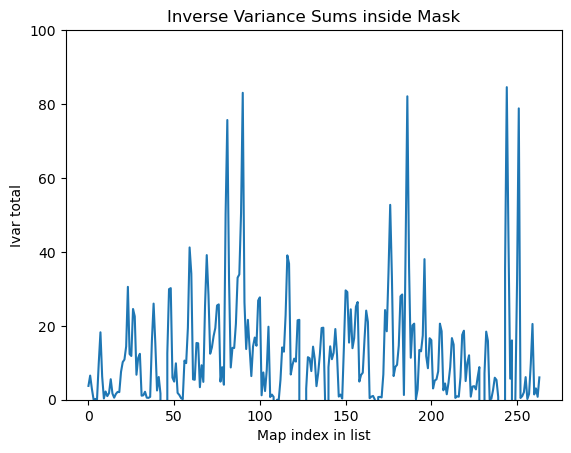

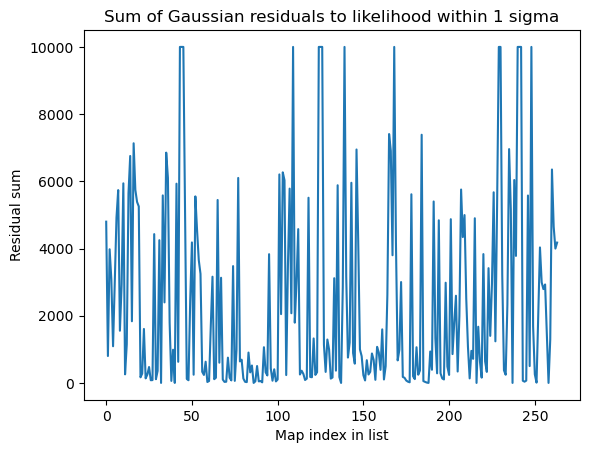

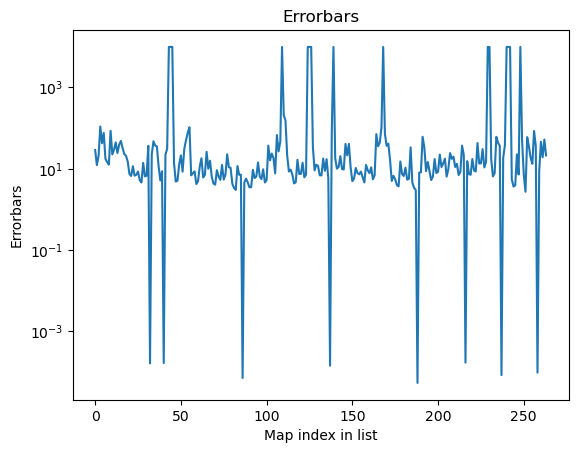

In [5]:
plt.plot(ivar_sums)
plt.ylim(0,100)
plt.title("Inverse Variance Sums inside Mask")
plt.ylabel("Ivar total")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.plot(residual_sums)
plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
plt.ylabel("Residual sum")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.semilogy(all_errbars)
plt.title("Errorbars")
plt.ylabel("Errorbars")
plt.xlabel("Map index in list")
plt.show()
plt.close()

In [6]:
maps[252]

'depth1_1617362620_pa4_f150_map.fits'

In [7]:
# List of indices from looking at likelihoods by eye
very_good = [20,21,23,24,25,26,27,29,30,38,47,48,59,60,63,64,68,69,70,72,73,75,80,81,82,87,89,90,91,93,94,97,
             99,100,105,113,114,115,116,117,119,120,122,123,131,132,136,150,151,157,162,173,174,175,176,177,
             179,180,182,183,185,186,187,196,197,200,212,219,243,244,245,251]
good = [1,22,39,51,56,57,58,66,71,76,78,79,83,84,85,88,96,98,121,128,130,134,141,142,144,145,149,152,153,154,155,
        156,158,159,160,163,181,189,190,193,195,199,202,205,211,213,217,218,221,222,232,233,247,250]
borderline = [2,8,37,61,92,102,129,147,161,198,203,204,224,227,254,259]
bad = [0,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,28,31,33,34,35,36,41,42,46,49,50,52,53,54,55,62,65,67,74,77,
       95,101,103,104,106,107,108,110,111,112,118,127,133,135,138,140,143,146,148,164,165,166,167,169,170,171,
       172,178,184,191,192,194,201,206,207,208,209,210,214,215,220,223,225,226,228,231,234,235,236,238,239,246,
       249,252,253,255,256,257,260,261,262,263]
cut = [43,44,45,109,124,125,126,139,168,229,230,240,241,242,248]
bad_fits = [32,40,86,137,188,216,237,258] # all bad ones because curve_fit fails to fit
print(len(very_good), len(good), len(borderline), len(bad), len(cut), len(bad_fits))
all_good = np.sort(very_good+good)
all_bad = np.sort(bad+cut)
all_not_cut = very_good+good+borderline+bad

72 54 16 99 15 8


In [8]:
# Previously, there had been some of these that rounded to zero, but those were caught by my new way of
# cutting maps that are only tapers
print(np.where(ivar_sums==0)[0])

[]


387
19.450000000000006
Fraction of good maps cut at index with all bad cut:  0.5634920634920635
Fraction borderline cut at index with all bad cut:  0.9375


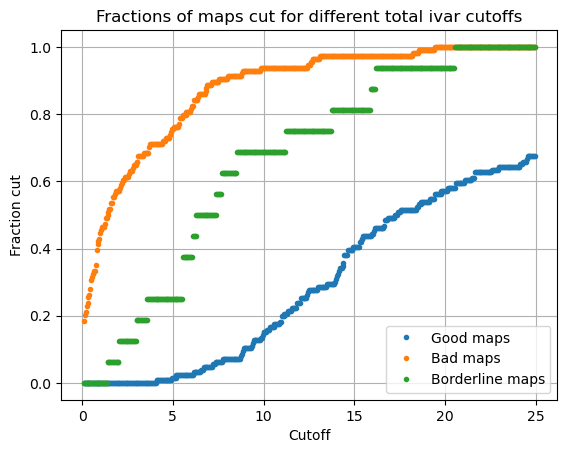

In [9]:
# Iterating over different ivar cutoffs to examine fraction that is cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(0.1,25.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    #print(outlier_indices_ivar_sums)
    num_outlier = len(outlier_indices_ivar_sums)
    for i in range(num_outlier):
        if outlier_indices_ivar_sums[i] in all_good: in_good += 1
        elif outlier_indices_ivar_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_ivar_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.grid()
plt.show()
plt.close()

549
255
Fraction of good maps cut at index with all bad cut:  0.4603174603174603
Fraction borderline cut at index with all bad cut:  1.0


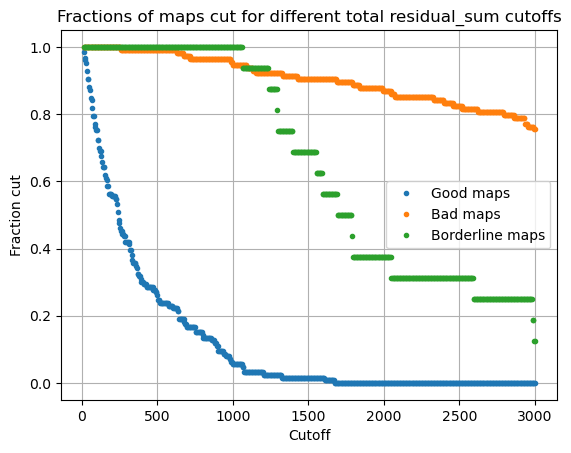

In [10]:
# Iterating over different cutoffs of residual_sums to examine fraction that is cut
# List of indices from looking at likelihoods by eye
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(3000,10,-5) # Want to cut big values
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_residual_sums)
    num_outlier = len(outlier_indices_residual_sums)
    for i in range(num_outlier):
        if outlier_indices_residual_sums[i] in all_good: in_good += 1
        elif outlier_indices_residual_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_residual_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual_sum cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.grid()
plt.show()
plt.close()


202
1990
Fraction of good maps cut at index with all bad cut:  0.0
Fraction borderline cut at index with all bad cut:  0.4375


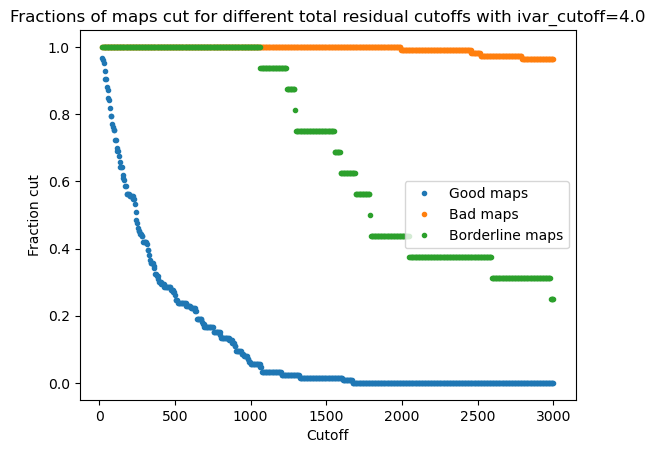

In [13]:
# Testing fixing the ivar cut and then sweeping out residual cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
ivar_cutoff = 4.0
cutoffs = np.arange(3000,15,-5)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < ivar_cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual cutoffs with ivar_cutoff="+str(ivar_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

In [16]:
print(good_fractions_cut[np.where(cutoffs==1600)[0][0]]*126)
print(border_fractions_cut[np.where(cutoffs==1600)[0][0]]*16)

2.0
10.0
